In [1]:
import import_ipynb
from fetch_data import get_stock_data

from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import joblib
import os
import sys
import datetime
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt

Index(['Open', 'High', 'Low', 'Close'], dtype='object')
Present date: 2025-10-31 00:00:00-04:00
Next valid date: 2025-11-02 23:00:00-05:00
Index(['Date', 'Close', 'Close_lag_1', 'Open_lag_1', 'High_lag_1', 'Low_lag_1',
       'Close_lag_2', 'Open_lag_2', 'High_lag_2', 'Low_lag_2', 'Close_lag_3',
       'Open_lag_3', 'High_lag_3', 'Low_lag_3', 'Close_lag_4', 'Open_lag_4',
       'High_lag_4', 'Low_lag_4', 'Close_lag_5', 'Open_lag_5', 'High_lag_5',
       'Low_lag_5', 'Close_lag_6', 'Open_lag_6', 'High_lag_6', 'Low_lag_6'],
      dtype='object')
Index(['Date', 'Close', 'Close_lag_1', 'Open_lag_1', 'High_lag_1', 'Low_lag_1',
       'Close_lag_2', 'Open_lag_2', 'High_lag_2', 'Low_lag_2', 'Close_lag_3',
       'Open_lag_3', 'High_lag_3', 'Low_lag_3', 'Close_lag_4', 'Open_lag_4',
       'High_lag_4', 'Low_lag_4', 'Close_lag_5', 'Open_lag_5', 'High_lag_5',
       'Low_lag_5', 'Close_lag_6', 'Open_lag_6', 'High_lag_6', 'Low_lag_6'],
      dtype='object')


In [11]:
def train_xgboost_model(ticker: str):
    df = get_stock_data(ticker.lower())
    X = df.drop(['Date', 'Close'], axis=1)
    Y = df["Close"]
    X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, shuffle=False)
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.05,
        "max_depth": 8,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 101
    }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=[(dtrain, 'train'), (dvalid, 'valid')],
        early_stopping_rounds=50,
        verbose_eval=50
    )
    y_pred = model.predict(dvalid)
    validation_dates = df['Date'].iloc[-len(y_valid):]
    plt.figure(figsize=(12, 6))
    plt.plot(validation_dates, y_valid.values, label='Actual Close Price', linewidth=2)
    plt.plot(validation_dates, y_pred, label='Predicted Close Price', linewidth=2)
    plt.title(f'{ticker.upper()} Model Analysis', fontsize=14)
    plt.xlabel('Date')
    plt.ylabel("Predicted 'Close' Price of the Stock")
    plt.legend()
    plt.grid(True)
    plt.show()
    


[0]	train-rmse:25.21495	valid-rmse:125.38449
[50]	train-rmse:2.28152	valid-rmse:39.52574
[100]	train-rmse:0.52176	valid-rmse:33.92096
[150]	train-rmse:0.30106	valid-rmse:33.61726
[200]	train-rmse:0.23658	valid-rmse:33.55996
[250]	train-rmse:0.19834	valid-rmse:33.55973
[271]	train-rmse:0.18548	valid-rmse:33.55999


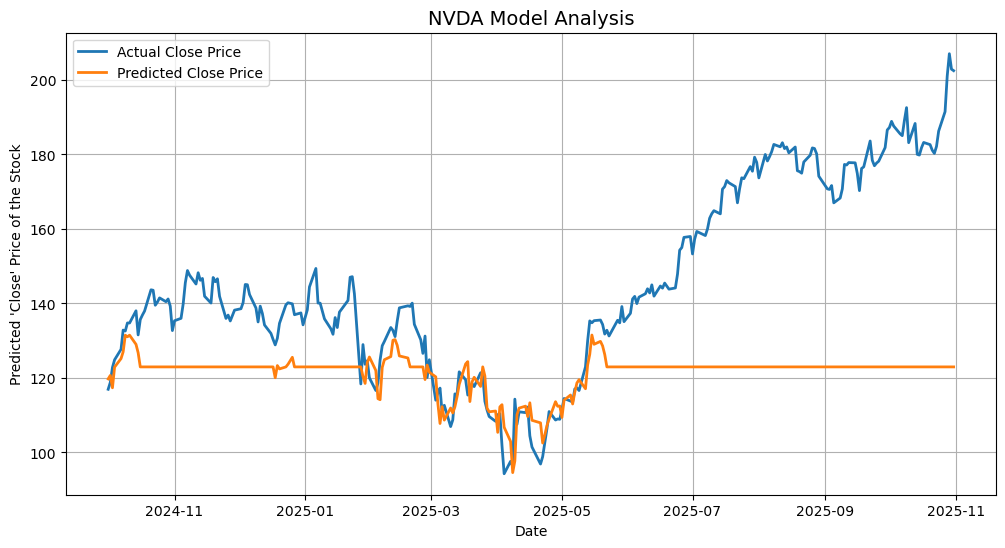

In [12]:
train_xgboost_model("NVDA")

[0]	train-rmse:59.10929	valid-rmse:131.08390
[50]	train-rmse:4.98172	valid-rmse:22.19665
[100]	train-rmse:1.20312	valid-rmse:15.05909
[150]	train-rmse:0.89017	valid-rmse:14.47710
[200]	train-rmse:0.71663	valid-rmse:14.32610
[250]	train-rmse:0.59952	valid-rmse:14.26397
[300]	train-rmse:0.51246	valid-rmse:14.23016
[350]	train-rmse:0.44622	valid-rmse:14.23543
[366]	train-rmse:0.43161	valid-rmse:14.22897


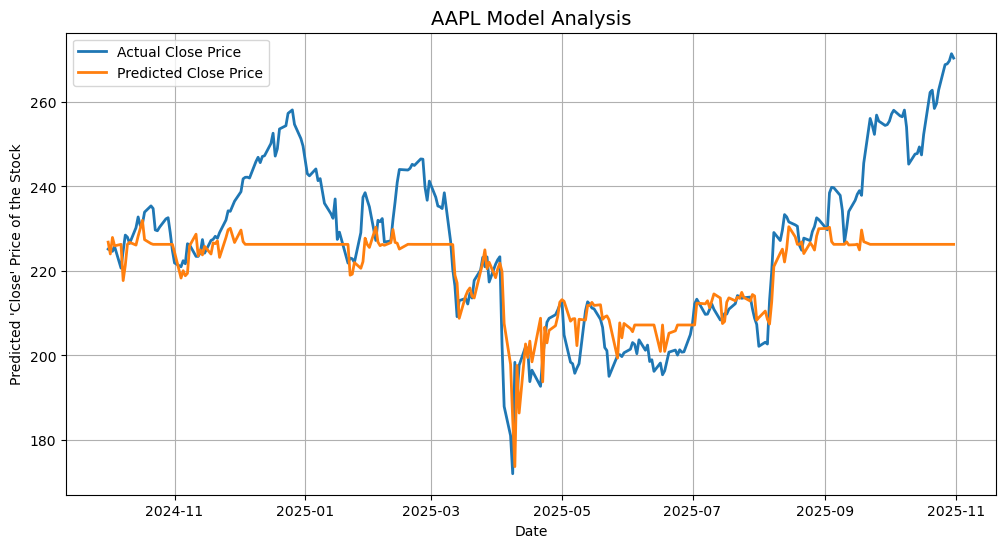

In [13]:
train_xgboost_model("AAPL")